# Overfitting and Regularization

## Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [5]:
set_config(display='diagram')

## Settings

In [6]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [7]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

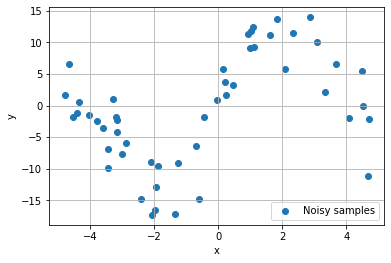

In [8]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

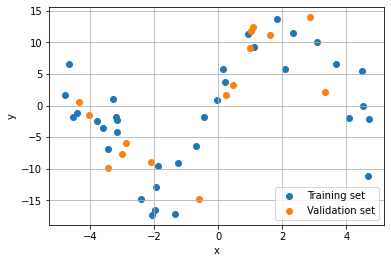

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [10]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [11]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

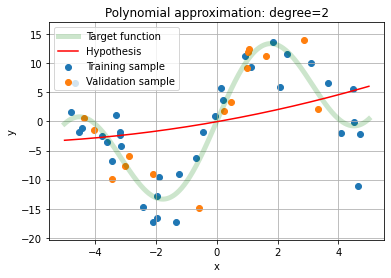

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

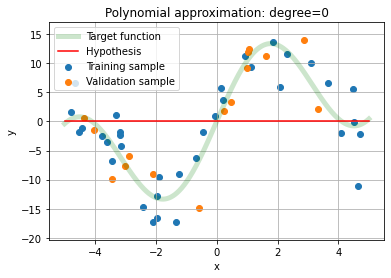

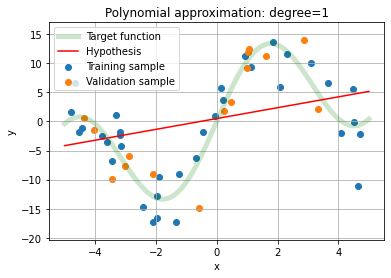

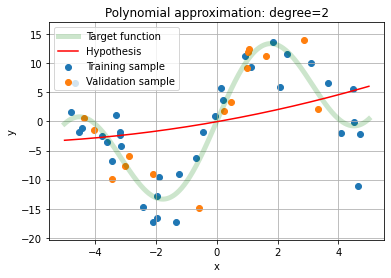

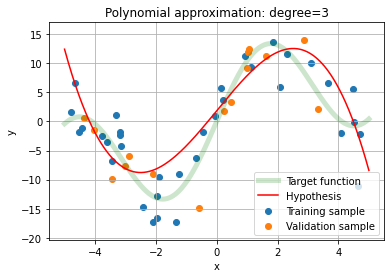

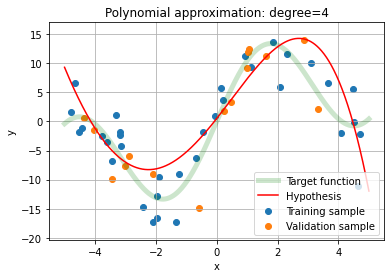

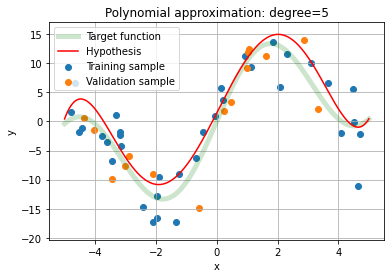

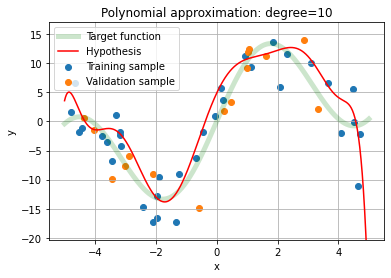

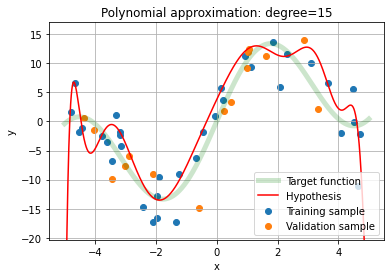

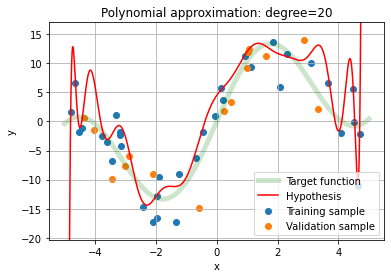

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

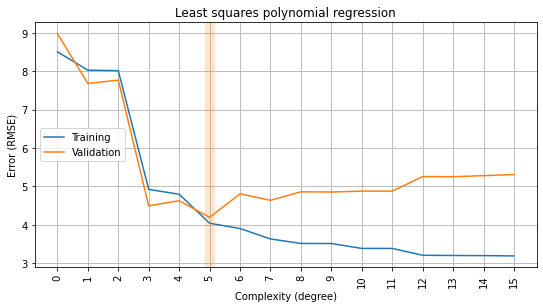

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [15]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

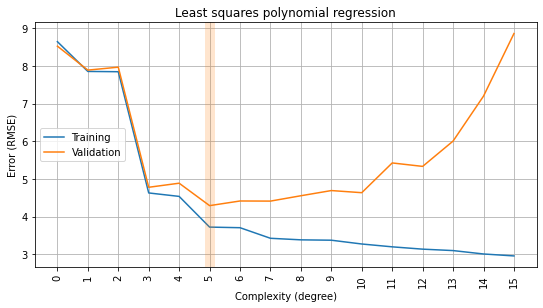

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

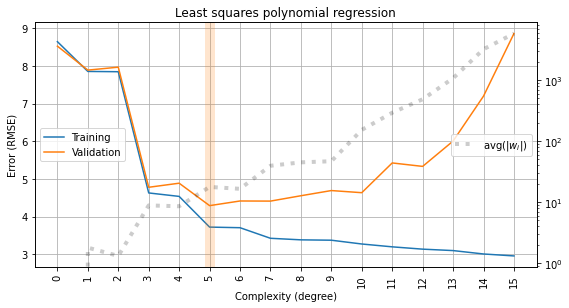

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

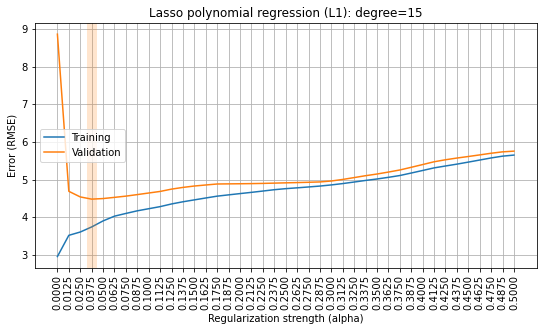

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

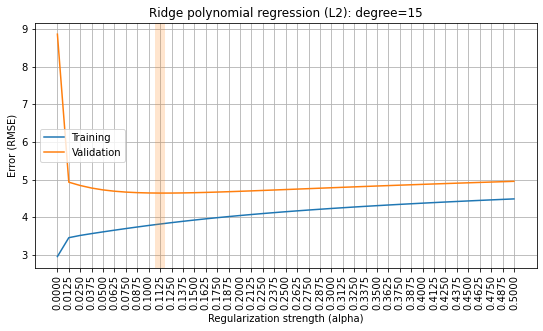

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

First of all, let's plot the regression coefficients calculated without any penalties.

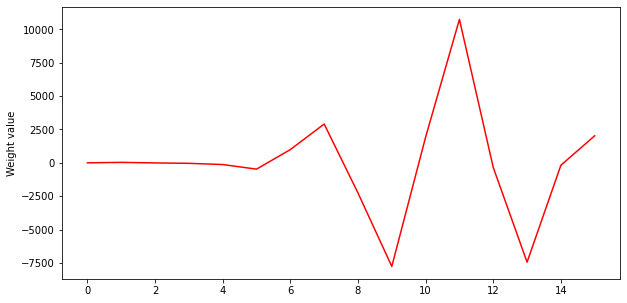

In [84]:
weights_no_penalty = make_model(degree=15, alpha=0).fit(X_train, y_train)['reg'].coef_

plt.figure(figsize=(10,5))
plt.plot(weights_no_penalty, color='red')
plt.xlabel('Coefficient number')
plt.ylabel('Weight value')
plt.show()

In [86]:
from scipy.stats import describe
# minimum and maximum weight values with no penalty
describe(weights_no_penalty).minmax

(-7770.357341277755, 10759.220095439809)

#### L1 - Lasso

Let's calculate all the weights for different alphas using Lasso Regression (L1 regularization):

In [ ]:
lasso_weights = []
for alpha in ALPHAS:    
    lasso_weights.append(make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_)

In the plot above there are regression coefficients for different alpha values except those for alpha=0, because for this alpha value the coefficients are the same as for the model without any penalties:

In [66]:
# L1 with alpha=0 is basically a model with no penalties
lasso_weights[0] == make_model(degree=15, alpha=0).fit(X_train, y_train)['reg'].coef_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

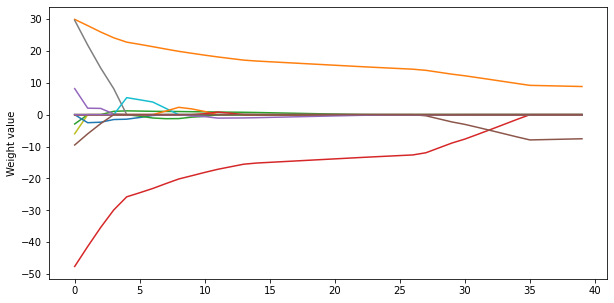

In [83]:
plt.figure(figsize=(10,5))
plt.plot(lasso_weights[1:])
plt.xlabel('Coefficient number')
plt.ylabel('Weight value')
plt.show()

In [103]:
# minimum and maximum weight values using L1 penalty for different alphas
for i in range(1, len(lasso_weights)):
    print(f"min and max weights = {describe(lasso_weights[i]).minmax}, alpha = {round(ALPHAS[i], 4)}")

min and max weights = (-47.583441756598724, 29.88455479721291), alpha = 0.0125
min and max weights = (-41.3352035959256, 27.920250542431273), alpha = 0.025
min and max weights = (-35.348023041013775, 25.915077182904188), alpha = 0.0375
min and max weights = (-29.88275786914532, 24.106128278868834), alpha = 0.05
min and max weights = (-25.758135478731916, 22.73877250750661), alpha = 0.0625
min and max weights = (-24.477391201363687, 22.042685810682794), alpha = 0.075
min and max weights = (-23.14437428049421, 21.31856752348283), alpha = 0.0875
min and max weights = (-21.627403087752405, 20.577652600399297), alpha = 0.1
min and max weights = (-20.16303156830077, 19.85880792033929), alpha = 0.1125
min and max weights = (-19.142190412136465, 19.254100096447136), alpha = 0.125
min and max weights = (-18.10019362266769, 18.657067661505593), alpha = 0.1375
min and max weights = (-17.126288251303183, 18.09984568985245), alpha = 0.15
min and max weights = (-16.321511299889032, 17.59812843467602

#### L2 - Ridge

Let's calculate all the weights for different alphas using Ridge Regression (L2 regularization):

In [ ]:
ridge_weights = []
for alpha in ALPHAS:    
    ridge_weights.append(make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_)

Here we also omit the coefficients for alpha=0 for the same reasons as with L1.

In [67]:
# L2 with alpha=0 is basically a model with no penalties
ridge_weights[0] == make_model(degree=15, alpha=0).fit(X_train, y_train)['reg'].coef_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

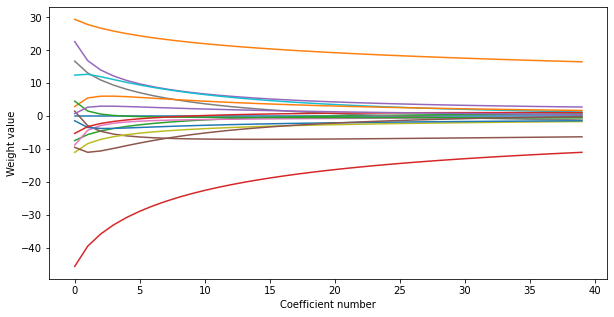

In [72]:
plt.figure(figsize=(10,5))
plt.plot(ridge_weights[1:])
plt.xlabel('Coefficient number')
plt.ylabel('Weight value')
plt.show()

In [105]:
# minimum and maximum weight values using L2 penalty
for i in range(1, len(ridge_weights)):
    print(f"min and max weights = {describe(ridge_weights[i]).minmax}, alpha = {round(ALPHAS[i], 4)}")

min and max weights = (-45.75365559122233, 29.42085373448097), alpha = 0.0125
min and max weights = (-39.5975850689913, 27.854603972830784), alpha = 0.025
min and max weights = (-35.870171024145044, 26.741795274536734), alpha = 0.0375
min and max weights = (-33.08515319420544, 25.84079150266423), alpha = 0.05
min and max weights = (-30.83985889237382, 25.077234929786012), alpha = 0.0625
min and max weights = (-28.959689740680247, 24.41426013027043), alpha = 0.075
min and max weights = (-27.348285770135693, 23.829213054333984), alpha = 0.0875
min and max weights = (-25.944676671936328, 23.306592714124204), alpha = 0.1
min and max weights = (-24.70694790016451, 22.835129593082964), alpha = 0.1125
min and max weights = (-23.604689764919918, 22.406309242087485), alpha = 0.125
min and max weights = (-22.614999647002257, 22.013523008945196), alpha = 0.1375
min and max weights = (-21.72014869198671, 21.651535837822244), alpha = 0.15
min and max weights = (-20.90611931767474, 21.31613262978632

### Magnitude Summary

As shown above, the weights for the LR model are drastically constrained both with L1 and L2 regularization.
The difference between minimum weight value with L1 regularizator and minimum weight value with no penalty is about 7000 and between maximum values is about 10700.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

We will be using lasso_weights array calculated in the previous exercise. <br>
Let's check if any of the calculated weights for L1 are zero and calculate how many weights are indeed zero for every alpha:

In [119]:
print(f"total number of weights = {len(lasso_weights[1])}")
for i, _ in enumerate(lasso_weights):
    print(f"alpha = {round(ALPHAS[i], 4)}, number of zero weights = {np.count_nonzero(lasso_weights[i]==0)}")

total number of weights = 16
alpha = 0.0, number of zero weights = 1
alpha = 0.0125, number of zero weights = 9
alpha = 0.025, number of zero weights = 10
alpha = 0.0375, number of zero weights = 10
alpha = 0.05, number of zero weights = 10
alpha = 0.0625, number of zero weights = 11
alpha = 0.075, number of zero weights = 10
alpha = 0.0875, number of zero weights = 10
alpha = 0.1, number of zero weights = 10
alpha = 0.1125, number of zero weights = 11
alpha = 0.125, number of zero weights = 10
alpha = 0.1375, number of zero weights = 9
alpha = 0.15, number of zero weights = 11
alpha = 0.1625, number of zero weights = 11
alpha = 0.175, number of zero weights = 11
alpha = 0.1875, number of zero weights = 12
alpha = 0.2, number of zero weights = 12
alpha = 0.2125, number of zero weights = 12
alpha = 0.225, number of zero weights = 12
alpha = 0.2375, number of zero weights = 12
alpha = 0.25, number of zero weights = 12
alpha = 0.2625, number of zero weights = 12
alpha = 0.275, number of z

#### L2

We will be using ridge_weights array calculated in the previous task. <br>
Let's check if any of the calculated weights for L2 are zero and calculate how many weights are indeed zero for every alpha:

In [118]:
print(f"total number of weights = {len(ridge_weights[1])}")
for i, _ in enumerate(ridge_weights):
    print(f"alpha = {round(ALPHAS[i], 4)}, number of zero weights = {np.count_nonzero(ridge_weights[i]==0)}")

total number of weights = 16
alpha = 0.0, number of zero weights = 1
alpha = 0.0125, number of zero weights = 1
alpha = 0.025, number of zero weights = 1
alpha = 0.0375, number of zero weights = 1
alpha = 0.05, number of zero weights = 1
alpha = 0.0625, number of zero weights = 1
alpha = 0.075, number of zero weights = 1
alpha = 0.0875, number of zero weights = 1
alpha = 0.1, number of zero weights = 1
alpha = 0.1125, number of zero weights = 1
alpha = 0.125, number of zero weights = 1
alpha = 0.1375, number of zero weights = 1
alpha = 0.15, number of zero weights = 1
alpha = 0.1625, number of zero weights = 1
alpha = 0.175, number of zero weights = 1
alpha = 0.1875, number of zero weights = 1
alpha = 0.2, number of zero weights = 1
alpha = 0.2125, number of zero weights = 1
alpha = 0.225, number of zero weights = 1
alpha = 0.2375, number of zero weights = 1
alpha = 0.25, number of zero weights = 1
alpha = 0.2625, number of zero weights = 1
alpha = 0.275, number of zero weights = 1
alp

### Sparsity Summary

Looking at out data on how many weights are indeed equal to zero for every alpha value, we can conclude that L1 regularizator really zeroes out some of the weights (sometimes even most of them). <br>
At the same time, L2 regularizator doesn't zero any coefficients, we can see that the number of zero weights is constant and is equal to the number of zero weights for alpha=0, i.e., to the number of zero weights for the LR model with no penalty. 

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html <br>
As we can learn from official sklearn documentation, or any other book on machine learning, scaling is the procedure of processing data so that the variable values share a similar scale, e.g. they will be normally distributed with the variance of 1 and centered around the mean value of 0. <br>
<br>
The important idea behind scaling is that if a certain feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. Therefore, the model would be built on a wrong assumption that this certain feature and its variance are significantly more important for the variance in our target variable. <br>
<br>
From that we can conclude that for the distance-based models and gradient descent it is best to scale our data to the more or less similar scale. For more complex algorithms, like tree-based algorithms (Decision Trees, Random Forest), scaling is not that important, but that's a whole other story.